In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
import matplotlib.pyplot as plt
import pickle

from keras.utils import np_utils
from keras import metrics
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import ZeroPadding2D
from keras.layers import ReLU
from keras.layers import Dropout
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = open("/content/drive/My Drive/RML2016.10b.dat",'rb')
pic = pickle.load(file, encoding = 'latin')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], pic.keys())))), [1,0])
X = []
labels = []
for mod in mods:
    for snr in snrs:
        X.append(pic[(mod,snr)])
        for i in range(pic[(mod,snr)].shape[0]):  labels.append((mod,snr))
file.close()
pic.clear()
X = np.vstack(X)
labels = np.array(labels)
print(X.shape)
print(labels.shape)

(1200000, 2, 128)
(1200000, 2)


In [ ]:
def choose_features(*args):
    chosen = ()
       
    for arg in args:
      if(arg == 'raw'):
        chosen += preprocessing.normalize(X[:,0]), preprocessing.normalize(X[:,1])
      if(arg == 'derivative'):
        chosen += preprocessing.normalize(np.gradient(X[:,0], axis = 1)), preprocessing.normalize(np.gradient(X[:,1], axis = 1))
      if(arg == 'integral'):
        chosen += preprocessing.normalize(np.cumsum(X[:,0], axis = 1)), preprocessing.normalize(np.cumsum(X[:,1], axis = 1))
    return np.stack(chosen, axis = 1)

In [ ]:
data = choose_features('raw')
print(data.shape)
print(labels.shape)

(1200000, 2, 128)
(1200000, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

y_mods_train = np.asarray(y_train)[:,0]
y_snr_train = np.asarray(y_train)[:,1].astype(int)
y_mods_test = np.asarray(y_test)[:,0]
y_snr_test = np.asarray(y_test)[:,1].astype(int)

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(['8PSK', 'AM-DSB','AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16',
       'QAM64', 'QPSK', 'WBFM'])
y_mods_train = lb.transform(y_mods_train)
y_mods_test = lb.transform(y_mods_test)
display(lb.classes_)

print(y_mods_train)
print(y_snr_train)

array(['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4',
       'QAM16', 'QAM64', 'QPSK', 'WBFM'], dtype='<U6')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
[-14 -14  10 ... -18   2 -20]


In [ ]:
in_shape = data[0].shape
out_shape = in_shape + tuple([1])
display(in_shape)
display(out_shape)

(2, 128)

(2, 128, 1)

CNN Model

In [ ]:
modelCNN = Sequential()
modelCNN.add(Reshape(out_shape, input_shape = in_shape))
modelCNN.add(Conv2D(64, (1, 3),activation='relu'))
modelCNN.add(Conv2D(16, (2, 3),activation='relu'))
modelCNN.add(Flatten())
modelCNN.add(Dense(128,activation='relu'))
modelCNN.add(Dense(11,activation='softmax'))
modelCNN.optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)
modelCNN.compile(loss='categorical_crossentropy',metrics=['accuracy'])

modelCNN.summary()

istoryCNN = modelCNN.fit(X_train, y_mods_train, epochs = 50, validation_split = 0.05, batch_size = 2048, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 126, 64)        256       
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 124, 16)        6160      
                                                                 
 flatten_3 (Flatten)         (None, 1984)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               254080    
                                                                 
 dense_7 (Dense)             (None, 11)                1419      
                                                                 
Total params: 261,915
Trainable params: 261,915
Non-tr

KeyboardInterrupt: ignored

#Vanilla RNN

In [ ]:
modelRNN = Sequential()
modelRNN.add(LSTM(128,return_sequences=True ,input_shape=X_train.shape[1:]))

modelRNN.add(Reshape(out_shape))#, input_shape=(2,200)))
modelRNN.add(ZeroPadding2D((0, 2)))

modelRNN.add(Conv2D(256, 2, 3,  padding='same', activation="relu",kernel_initializer='glorot_uniform'))
modelRNN.add(Dropout(0.5))
modelRNN.add(ZeroPadding2D((0, 2)))
modelRNN.add(Conv2D(128, 1, 3, padding='valid', activation="relu",kernel_initializer='glorot_uniform'))
modelRNN.add(Dropout(0.5))


modelRNN.add(Flatten())
modelRNN.add(Dense(128,activation='relu',kernel_initializer='glorot_uniform'))
modelRNN.add(Dense(11,activation='softmax',kernel_initializer='glorot_uniform'))
modelRNN.optimizer = tf.keras.optimizers.Adam()
modelRNN.compile(loss='categorical_crossentropy',metrics=['accuracy'])
modelRNN.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
historyRNN = modelRNN.fit(X_train, y_mods_train, epochs = 350, validation_split = 0.05, batch_size = 1024, callbacks=[learning_rate_reduction, EarlyStopping(patience = 3, restore_best_weights = True)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            131584    
                                                                 
 reshape (Reshape)           (None, 4, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 4, 132, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 2, 44, 256)        1280      
                                                                 
 dropout (Dropout)           (None, 2, 44, 256)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 2, 48, 256)       0         
 ng2D)                                                  

KeyboardInterrupt: ignored

#LTSM Model

In [ ]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(128,return_sequences=True ,input_shape=X_train.shape[1:]))

modelLSTM.add(Reshape(out_shape))#, input_shape=(2,200)))
modelLSTM.add(ZeroPadding2D((0, 2)))

modelLSTM.add(Conv2D(256, 2, 3,  padding='same', activation="relu"))
modelLSTM.add(Dropout(0.5))
modelLSTM.add(ZeroPadding2D((0, 2)))
modelLSTM.add(Conv2D(128, 1, 3, padding='valid', activation="relu"))
modelLSTM.add(Dropout(0.5))


modelLSTM.add(Flatten())
modelLSTM.add(Dense(128,activation='relu'))
modelLSTM.add(Dense(11,activation='softmax'))
modelLSTM.optimizer = tf.keras.optimizers.Adam()
modelLSTM.compile(loss='categorical_crossentropy',metrics=['accuracy'])
modelLSTM.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
historyLSTM = modelLSTM.fit(X_train, y_mods_train, epochs = 50, validation_split = 0.05, batch_size = 1024, callbacks=[learning_rate_reduction, EarlyStopping(patience = 15, restore_best_weights = True)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4, 128)            131584    
                                                                 
 reshape_1 (Reshape)         (None, 4, 128, 1)         0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 4, 132, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 44, 256)        1280      
                                                                 
 dropout_2 (Dropout)         (None, 2, 44, 256)        0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 2, 48, 256)       0         
 ng2D)                                                

KeyboardInterrupt: ignored

In [ ]:
def SNRVsAccPlot(predicted_labels, true_labels, snrs):
  
  snr_sorted = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in snr_sorted:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy Vs different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'bo--')
  plt.grid(True)
  plt.show()

In [ ]:
def SNRVsAccPrint(predicted_labels, true_labels, snrs):
  
  snr_sorted = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in snr_sorted:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  display(df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = snr_sorted, index = ['accuracy']).round(2))

In [ ]:
def plot_confusion_matrix(y_pred, y_true):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  array = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(array)
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
  plt.show()

In [ ]:
#y_pred = modelCNN.predict(X_test)
#y_pred = modelRNN.predict(X_test)
y_pred = modelLSTM.predict(X_test)

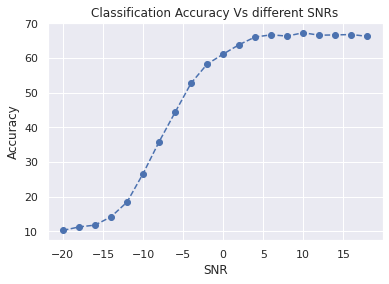

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.31,11.31,11.84,14.22,18.46,26.65,35.84,44.36,52.77,58.25,61.15,63.88,66.1,66.71,66.36,67.32,66.61,66.69,66.8,66.28


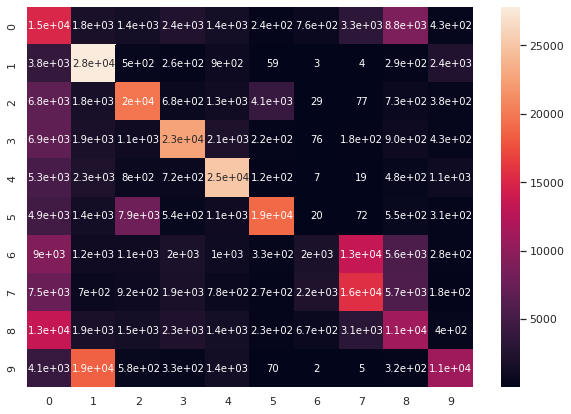

In [ ]:
SNRVsAccPlot(y_pred, y_mods_test, y_snr_test)
SNRVsAccPrint(y_pred, y_mods_test, y_snr_test)
plot_confusion_matrix(y_pred,y_mods_test)